<a href="https://colab.research.google.com/github/AadarshLN/Stock-Price-Prediction-Using-RNNs/blob/main/Stock_Price_Prediction_Using_RNN_tf_combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1234600646.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1234600646.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1234600646.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1234600646.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)[['Close']]
[*********************100%*******************

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1892
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0225
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0110
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0071
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0048
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0040
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0036
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0030
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0027
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0023
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0024
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0022
Epoch 13/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0020
Epoch 14/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0020
Epoch 15/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0020
Epoc

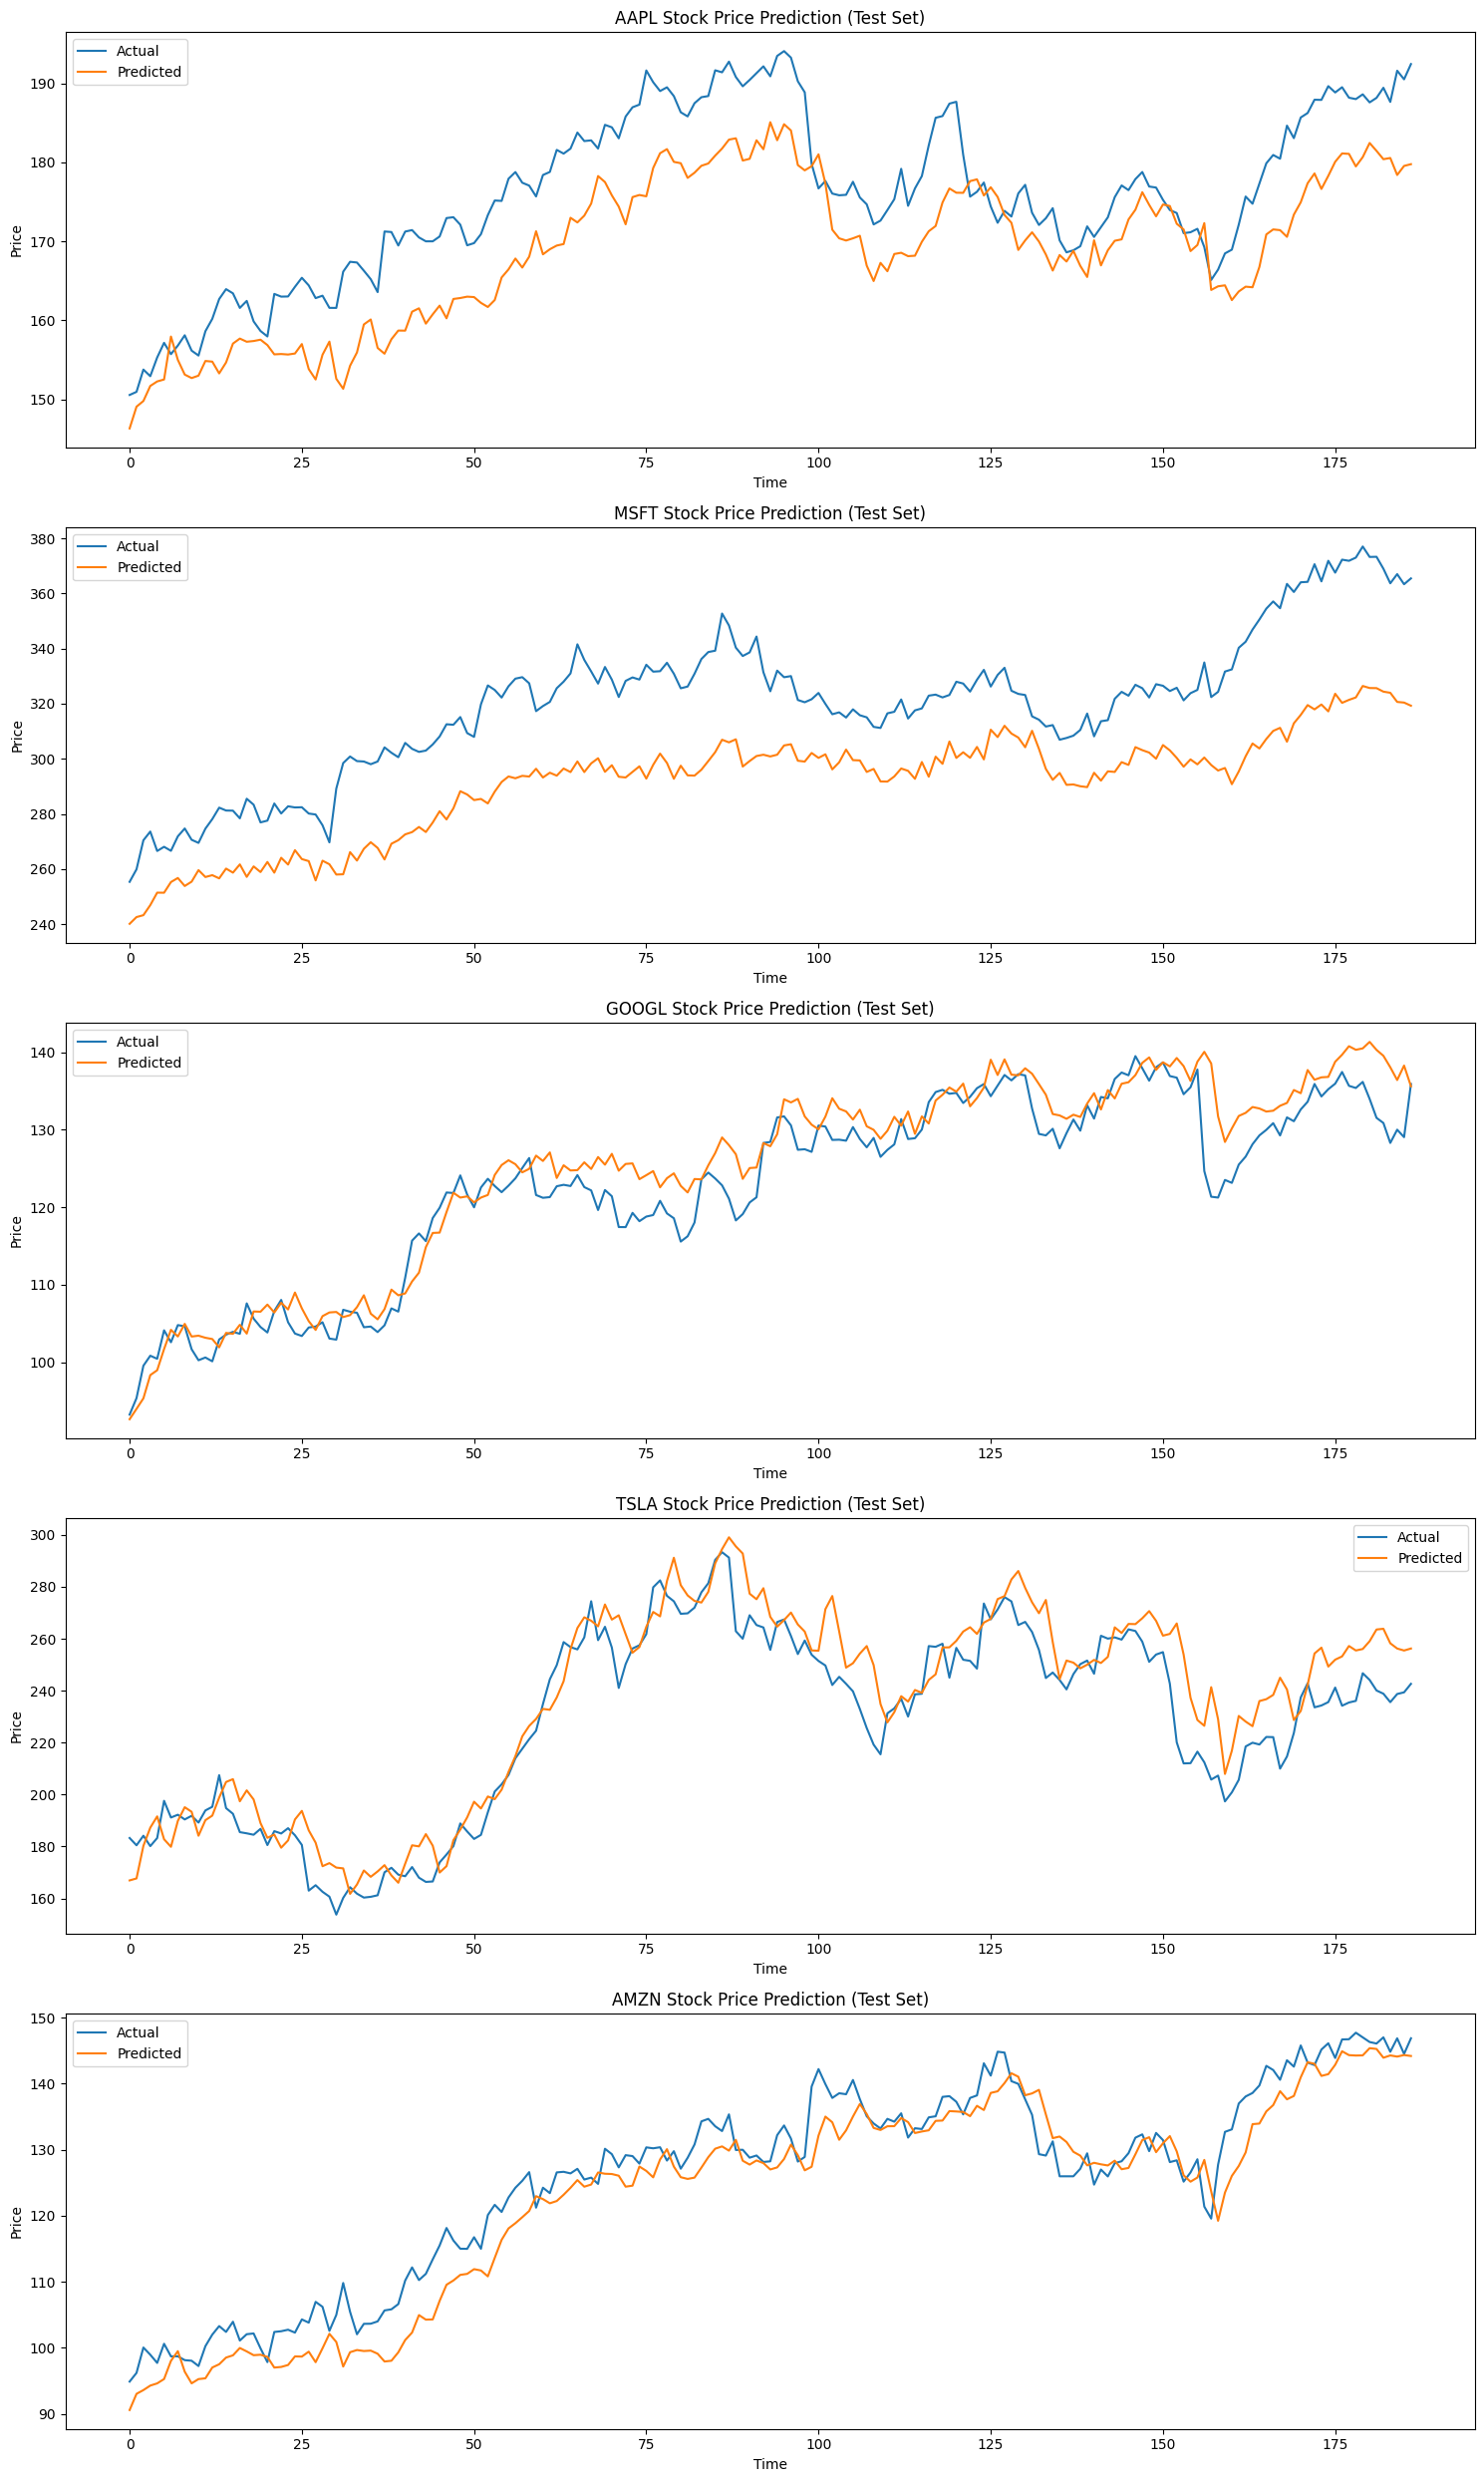

In [ ]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

def multi_stock_rnn_train_test(tickers, start_date, end_date,
                               look_back=60, epochs=50, batch_size=64):

    stock_data = {}
    scalers = {}
    for ticker in tickers:
        data = yf.download(ticker, start=start_date, end=end_date)[['Close']]
        scaler = MinMaxScaler()
        data['Close'] = scaler.fit_transform(data[['Close']])
        stock_data[ticker] = data
        scalers[ticker] = scaler

    min_length = min(len(d) for d in stock_data.values())
    for ticker in tickers:
        stock_data[ticker] = stock_data[ticker][-min_length:]
    def create_dataset_multi(data_dict, look_back):
        X, Y = [], []
        data_arrays = [data['Close'].values for data in data_dict.values()]
        data_arrays = np.hstack(data_arrays)

        for i in range(len(data_arrays) - look_back):
            X.append(data_arrays[i:i + look_back, :])
            Y.append(data_arrays[i + look_back, :])
        return np.array(X), np.array(Y)

    X, Y = create_dataset_multi(stock_data, look_back)
    train_size = int(len(X) * 0.8)

    X_train, X_test = X[:train_size], X[train_size:]
    Y_train, Y_test = Y[:train_size], Y[train_size:]

    model = Sequential()
    model.add(SimpleRNN(50, return_sequences=True,
                        input_shape=(look_back, len(tickers))))
    model.add(SimpleRNN(50))
    model.add(Dense(len(tickers)))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train,
              epochs=epochs,
              batch_size=batch_size,
              verbose=1)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    print("\n--- Test Set Performance ---")
    plt.figure(figsize=(15, 5 * len(tickers)))

    for i, ticker in enumerate(tickers, 1):
        Y_test_inv = scalers[ticker].inverse_transform(
            Y_test[:, i - 1].reshape(-1, 1)
        )
        test_pred_inv = scalers[ticker].inverse_transform(
            test_pred[:, i - 1].reshape(-1, 1)
        )

        rmse = math.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))
        mae = mean_absolute_error(Y_test_inv, test_pred_inv)

        print(f"{ticker} Test RMSE: {rmse:.3f}, Test MAE: {mae:.3f}")

        plt.subplot(len(tickers), 1, i)
        plt.plot(Y_test_inv, label="Actual")
        plt.plot(test_pred_inv, label="Predicted")
        plt.title(f"{ticker} Stock Price Prediction (Test Set)")
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.legend()

    plt.tight_layout()
    plt.show()

tickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "AMZN"]
multi_stock_rnn_train_test(
    tickers,
    start_date="2020-01-01",
    end_date="2025-01-08",
    look_back=60,
    epochs=50,
    batch_size=64
)
